### 功率模型


In [241]:

#导入基础库
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import math
from tqdm import tqdm


In [242]:
#读取文件，换成data_1即可测试另一个数据集
data = pd.read_csv(
    './data_1.csv', header=0,names=['n(r/min)', 'f(mm/r)', 'ap(mm)', 'MRR(mm3/s)', 'P(W)'])
data

,n(r/min),f(mm/r),ap(mm),MRR(mm3/s),P(W)
1,500,140,2.0,9,0.93
2,900,140,2.0,9,1.00
3,1300,140,2.0,9,1.10
4,1700,140,2.0,9,1.19
5,2100,140,2.0,9,1.29
6,500,180,2.0,3,0.89
7,900,180,2.0,3,0.92
8,1300,180,2.0,3,1.03
9,1700,180,2.0,3,1.13
10,2100,180,2.0,3,1.22


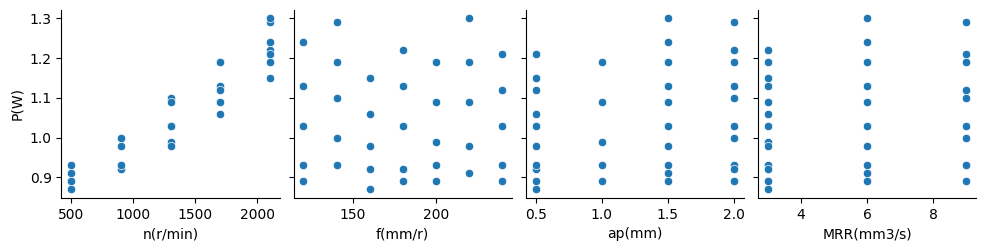

In [243]:
#观察各个feature与P(W)的关系
import seaborn as sns
sns.pairplot(data, x_vars=['n(r/min)','f(mm/r)','ap(mm)','MRR(mm3/s)'], y_vars=['P(W)'])


In [244]:
a = np.array([1,2,3,4,5])
np.std(a)

1.4142135623730951

In [245]:
#搭建模型网络
class Pw_Model(nn.Module):
    def __init__(self, input_dim):
        super(Pw_Model, self).__init__()
        self.layers = nn.Sequential(
            #层数变少效果变好了（数据太简单了）
            nn.Linear(input_dim, 2048),
            nn.ReLU(),
            # nn.Linear(2048,256),
            # nn.ReLU(),
            nn.Linear(2048, 1)
        )

    def forward(self, x):
        x = self.layers(x)
        x = x.squeeze(1)  # (B, 1) -> (B)
        return x
    
#数据加载转换tensor类
class Pw_Dataset(Dataset):
    '''
    x: Features.
    y: Targets, if none, do prediction.
    '''
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)


In [246]:
#hyperparameters配置
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'n_epochs': 1000,     # Number of epochs.
    'batch_size': 256,
    'learning_rate': 1e-4,
}


In [247]:
#标准化操作示例
data_normalized = data
data_normalized.apply(lambda x: (x - np.mean(x)) / (np.std(x)))


,n(r/min),f(mm/r),ap(mm),MRR(mm3/s),P(W)
1,-1.414214,-1.0,1.212678,1.371989,-0.919289
2,-0.707107,-1.0,1.212678,1.371989,-0.368615
3,0.000000,-1.0,1.212678,1.371989,0.418063
4,0.707107,-1.0,1.212678,1.371989,1.126073
5,1.414214,-1.0,1.212678,1.371989,1.912751
6,-1.414214,0.0,1.212678,-1.028992,-1.233960
7,-0.707107,0.0,1.212678,-1.028992,-0.997957
8,0.000000,0.0,1.212678,-1.028992,-0.132611
9,0.707107,0.0,1.212678,-1.028992,0.654066
10,1.414214,0.0,1.212678,-1.028992,1.362076


In [248]:
#初始化数据
#打乱
data = data.sample(frac=1.0)
#标准化(理论上先划分再归一化，这里偷懒了，对于data_1不归一化效果也很好，因为已经做过量纲处理了)
data_normalized = data.apply(lambda x: (x - np.mean(x)) / (np.std(x)))
#划分训练集和验证集
divide = int(data.shape[0]*0.85)
train_data, test_data = data_normalized.iloc[:divide], data_normalized.iloc[divide:data.shape[0]]
train_data, test_data = train_data.values,test_data.values

train_y , test_y = train_data[:,-1],test_data[:,-1]
train_x , test_x = train_data[:,:-1],test_data[:,:-1]

train_dataset, test_dataset = Pw_Dataset(
    train_x, train_y), Pw_Dataset(test_x, test_y)
train_loader = DataLoader(
    train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
test_loader = DataLoader(
    test_dataset, batch_size=config['batch_size'], shuffle=False, pin_memory=True)


In [249]:
#优化函数，损失函数，数据迁移
model = Pw_Model(input_dim=train_x.shape[1]).to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(
    model.parameters(), lr=config['learning_rate'])



In [250]:
#训练
def trainer(train_loader, model, config, device):
    n_epochs,step = config['n_epochs'],0
    loss_record = []
    for epoch in range(n_epochs):
        model.train()  # Set your model to train mode.
        # tqdm is a package to visualize your training progress.
        train_pbar = tqdm(train_loader, leave=False)
        for x, y in train_pbar:
            optimizer.zero_grad()               # Set gradient to zero.
            x, y = x.to(device), y.to(device)   # Move your data to device.
            pred = model(x)
            loss = criterion(pred, y)
            # Compute gradient(backpropagation).
            loss.backward()
            optimizer.step()                    # Update parameters.
            step += 1
            loss_record.append(loss.detach().item())
        mean_train_loss = sum(loss_record)/len(loss_record)
        if(epoch+1)%50==0:
            print(f'Epoch[{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss: .8f}')
    return loss_record


In [251]:
#测试
def test(test_loader,model,device):
    model.eval()  # Set your model to evaluation mode.
    loss_record = []
    predict = []
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            pred = model(x)
            predict.append(pred)
            loss = criterion(pred, y)
        loss_record.append(loss.item())
    mean_test_loss = sum(loss_record)/len(loss_record)
    print(
        f'test loss: {mean_test_loss:.8f}')
    return predict


Epoch[50/1000]: Train loss:  0.38501084


Epoch[100/1000]: Train loss:  0.19798491


Epoch[150/1000]: Train loss:  0.13425422


Epoch[200/1000]: Train loss:  0.10202507


Epoch[250/1000]: Train loss:  0.08251364


Epoch[300/1000]: Train loss:  0.06939851


Epoch[350/1000]: Train loss:  0.05995693


Epoch[400/1000]: Train loss:  0.05282273


Epoch[450/1000]: Train loss:  0.04723415


Epoch[500/1000]: Train loss:  0.04273279


Epoch[550/1000]: Train loss:  0.03902584


Epoch[600/1000]: Train loss:  0.03591741


Epoch[650/1000]: Train loss:  0.03327134


Epoch[700/1000]: Train loss:  0.03099027


Epoch[750/1000]: Train loss:  0.02900261


Epoch[800/1000]: Train loss:  0.02725449


Epoch[850/1000]: Train loss:  0.02570454


Epoch[900/1000]: Train loss:  0.02432049


Epoch[950/1000]: Train loss:  0.02307682


Epoch[1000/1000]: Train loss:  0.02195307


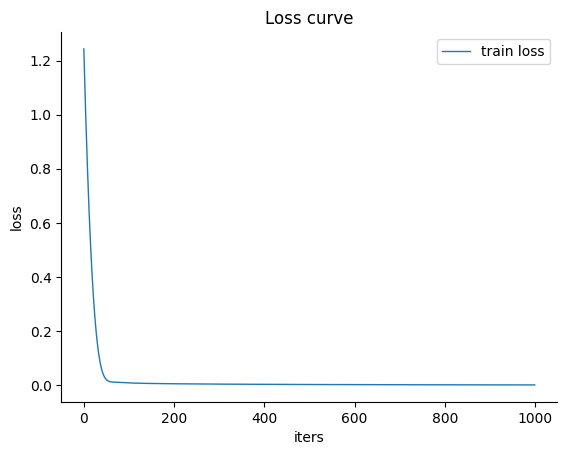

In [252]:
y_train_loss = trainer(train_loader, model, config, device)      # loss值，即y轴
x_train_loss = range(len(y_train_loss))			 # loss的数量，即x轴
plt.figure()

# 去除顶部和右边框框
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('iters')    # x轴标签
plt.ylabel('loss')     # y轴标签

# 以x_train_loss为横坐标，y_train_loss为纵坐标，曲线宽度为1，实线，增加标签，训练损失，
plt.plot(x_train_loss, y_train_loss, linewidth=1, linestyle="solid", label="train loss")
plt.legend()
plt.title('Loss curve')
plt.show()


In [253]:

predict = test(test_loader,model,device)

test loss: 0.00776521


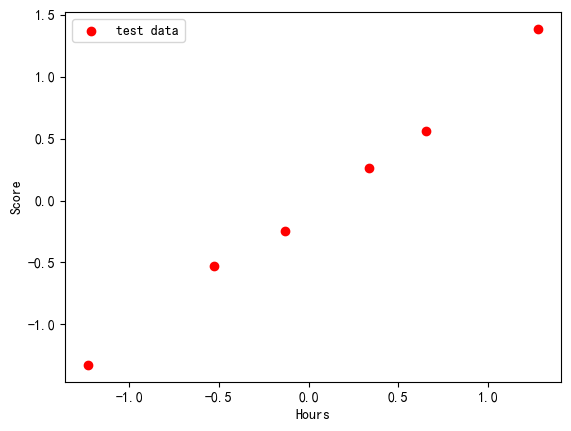

0.9883006430755764


In [277]:
from sklearn.metrics import r2_score
real= np.array(test_y)
compute = predict[0].cuda().cpu().numpy()
#测试数据散点图
plt.scatter(real, compute, color='red', label="test data")
#添加图标标签
plt.legend(loc=2)
plt.xlabel("Hours")
plt.ylabel("Score")
#显示图像
plt.show()
#计算拟合优度
score = r2_score(real, compute)
print(score)
